# Random Forest

In [22]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from src.randomforest import RandomForest
import src.utils as utils

### Without outliers

In [3]:
df = pd.read_csv("data/diamonds.csv")
X_train, X_test, y_train, y_test = utils.preprocessing_LOS(df)

In [7]:
param_grid = {
	"n_estimators": [10, 50, 100, 200],
	"max_depth": [2, 3, 4],
	"bootstrap": [True, False]
}

grid_search = GridSearchCV(RandomForest(), param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5; 1/24] START bootstrap=True, max_depth=2, n_estimators=10...............
[CV 1/5; 1/24] END bootstrap=True, max_depth=2, n_estimators=10;, score=(train=0.578, test=0.577) total time=   0.0s
[CV 2/5; 1/24] START bootstrap=True, max_depth=2, n_estimators=10...............
[CV 2/5; 1/24] END bootstrap=True, max_depth=2, n_estimators=10;, score=(train=0.576, test=0.573) total time=   0.0s
[CV 3/5; 1/24] START bootstrap=True, max_depth=2, n_estimators=10...............
[CV 3/5; 1/24] END bootstrap=True, max_depth=2, n_estimators=10;, score=(train=0.575, test=0.581) total time=   0.0s
[CV 4/5; 1/24] START bootstrap=True, max_depth=2, n_estimators=10...............
[CV 4/5; 1/24] END bootstrap=True, max_depth=2, n_estimators=10;, score=(train=0.577, test=0.575) total time=   0.0s
[CV 5/5; 1/24] START bootstrap=True, max_depth=2, n_estimators=10...............
[CV 5/5; 1/24] END bootstrap=True, max_depth=2, n_estimators=10;,

GridSearchCV(cv=5, estimator=RandomForest(),
             param_grid={'bootstrap': [True, False], 'max_depth': [2, 3, 4],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='accuracy', verbose=10)

In [8]:
sorted(zip(grid_search.cv_results_["mean_test_score"], grid_search.cv_results_["params"]), reverse=True)

[(0.7172084383707045,
  {'bootstrap': False, 'max_depth': 4, 'n_estimators': 200}),
 (0.717181902613772, {'bootstrap': True, 'max_depth': 4, 'n_estimators': 100}),
 (0.7171553668568396,
  {'bootstrap': True, 'max_depth': 4, 'n_estimators': 200}),
 (0.7169961523152447,
  {'bootstrap': False, 'max_depth': 4, 'n_estimators': 100}),
 (0.7169165450444475,
  {'bootstrap': False, 'max_depth': 4, 'n_estimators': 50}),
 (0.7167042589889877, {'bootstrap': True, 'max_depth': 4, 'n_estimators': 50}),
 (0.7164389014196629, {'bootstrap': True, 'max_depth': 4, 'n_estimators': 10}),
 (0.7161470080934059,
  {'bootstrap': False, 'max_depth': 3, 'n_estimators': 50}),
 (0.7161204723364734,
  {'bootstrap': True, 'max_depth': 3, 'n_estimators': 200}),
 (0.7160674008226084,
  {'bootstrap': False, 'max_depth': 3, 'n_estimators': 200}),
 (0.7159347220379462, {'bootstrap': True, 'max_depth': 3, 'n_estimators': 50}),
 (0.7159081862810136,
  {'bootstrap': False, 'max_depth': 3, 'n_estimators': 100}),
 (0.71582857

From this grid search, we conclude that the `max_depth` is the one increasing the most the accuracy (up to 0.71), followed by the `n_estimators`, both directly proportionally. `bootstrap` is not influencing that much, so we will set it to `True`, as we think it might be more beneficial to avoid overfitting. Also, altough higher `n_estimators` do increase the accuracy, the difference between 100 and 200 is insignificant, so we will use 100 as it's less computationally expensive.

In [40]:
model = RandomForest(n_estimators=100, max_depth=4, bootstrap=True)
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pikur\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.7160674008226084,
 'precision': 0.7422037422037422,
 'recall': 0.5639810426540285,
 'f1': 0.6409335727109515}

The warning says us that the model is predicting no samples for some classes.

In [41]:
y_train2.value_counts()

2    12835
3     7679
4     7037
1     2387
0      210
Name: cut, dtype: int64

We can see that there are very few samples for class `0` in the training set, which the model might be missing, and it's not reflected in the accuracy at all.  
We will train the Random Forest again, this time with `class_weight = "balanced"`, so that classes with low frequency have more weigth.

In [43]:
model = RandomForest(n_estimators=100, max_depth=4, bootstrap=True, class_weight="balanced")
model.fit(X_train2, y_train2)
model.compute_metrics(X_val, y_val)

{'accuracy': 0.6939100437839989,
 'precision': 0.5390898483080513,
 'recall': 0.7298578199052133,
 'f1': 0.6201342281879194}

We observe that accuracy decreases a bit, and f1 score staying more or less constant indicates that the decrease in precision is offset by the increase in recall.

In [46]:
pd.Series(model.predict(X_val)).value_counts()


2    3861
3    2667
1     857
4     100
0      52
dtype: int64

Indeed, the frequency of each class in the predictions is proportional to the frequency in the training set.

Finally, as we observed, increasing the `max_depth` yields better results, so we will increase it exagerately to see to what end we can bring this Random Forest.  
As we try a big range of parameters, we use Randomized Search to accelerate the process.

In [55]:
param_grid = {
	"max_depth": list(range(5, 25)),
}

random_search = RandomizedSearchCV(RandomForest(class_weight="balanced"), param_grid, cv=5, scoring="accuracy", 
								   return_train_score=True, verbose=10, n_iter=10)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=6................................................
[CV 1/5; 1/10] END max_depth=6;, score=(train=0.703, test=0.698) total time=   0.5s
[CV 2/5; 1/10] START max_depth=6................................................
[CV 2/5; 1/10] END max_depth=6;, score=(train=0.699, test=0.703) total time=   0.4s
[CV 3/5; 1/10] START max_depth=6................................................
[CV 3/5; 1/10] END max_depth=6;, score=(train=0.699, test=0.695) total time=   0.4s
[CV 4/5; 1/10] START max_depth=6................................................
[CV 4/5; 1/10] END max_depth=6;, score=(train=0.700, test=0.701) total time=   0.5s
[CV 5/5; 1/10] START max_depth=6................................................
[CV 5/5; 1/10] END max_depth=6;, score=(train=0.702, test=0.694) total time=   0.4s
[CV 1/5; 2/10] START max_depth=18...............................................
[CV 1/5; 2/10] END max_depth=18;,

RandomizedSearchCV(cv=5, estimator=RandomForest(class_weight='balanced'),
                   param_distributions={'max_depth': [5, 6, 7, 8, 9, 10, 11, 12,
                                                      13, 14, 15, 16, 17, 18,
                                                      19, 20, 21, 22, 23, 24]},
                   return_train_score=True, scoring='accuracy', verbose=10)

In [56]:
sorted(zip(random_search.cv_results_["mean_test_score"], random_search.cv_results_["params"]), reverse=True)

[(0.78214143558445, {'max_depth': 23}),
 (0.7820883640705851, {'max_depth': 20}),
 (0.7819291495289903, {'max_depth': 24}),
 (0.7819026137720579, {'max_depth': 22}),
 (0.7811330768210164, {'max_depth': 18}),
 (0.7772057847950112, {'max_depth': 16}),
 (0.761549688204856, {'max_depth': 12}),
 (0.7445668037680775, {'max_depth': 10}),
 (0.7025607005439831, {'max_depth': 7}),
 (0.6982884436778558, {'max_depth': 6})]

Values of `max_depth` over 20 seem to achieve the most accuracy in the validation set, despite highly overfitting the training set. We will now compare the metrics of setting `max_depth` to 16 and to 24.

In [61]:
model_24 = RandomForest(n_estimators=100, max_depth=24, bootstrap=True, class_weight="balanced")
model_24.fit(X_train2, y_train2)
model_24.compute_metrics(X_val, y_val)

{'accuracy': 0.7806819689531644,
 'precision': 0.798828125,
 'recall': 0.6461295418641391,
 'f1': 0.714410480349345}

In [65]:
model_16 = RandomForest(n_estimators=100, max_depth=16, bootstrap=True, class_weight="balanced")
model_16.fit(X_train2, y_train2)
model_16.compute_metrics(X_val, y_val)

{'accuracy': 0.7790898235372165,
 'precision': 0.7730496453900709,
 'recall': 0.688783570300158,
 'f1': 0.7284878863826233}

In [68]:
_ = model_24.compare(model_16, X_val, y_val)

accuracy 0.0015921454159479875
precision 0.025778479609929073
recall -0.042654028436018954
f1 -0.014077406033278339
confusion matrix [[  0   0   0   0   0]
 [  0 -27   2   4  21]
 [  0  -2   9 -21  14]
 [  0  -4   2 -38  40]
 [  0 -19  13 -62  68]]


The comparison shows us that `model_24` has higher accuracy and precision than `model_16`, but less recall and f1. The lines of 0 in the **difference** confusion matrix suggests that both model perform equally good in the class 0 (the one with few samples), so we are happy.  
Actually, the difference between both is very small, so we will take `max_depth = 16` as it's less computationally expensive and less complex.

In [77]:
model = RandomForest(n_estimators=100, max_depth=16, bootstrap=True, class_weight="balanced")
model.fit(X_train, y_train)
model.compute_metrics(X_test, y_test)

{'accuracy': 0.7853958819783485,
 'precision': 0.7866242038216561,
 'recall': 0.6997167138810199,
 'f1': 0.7406296851574214}

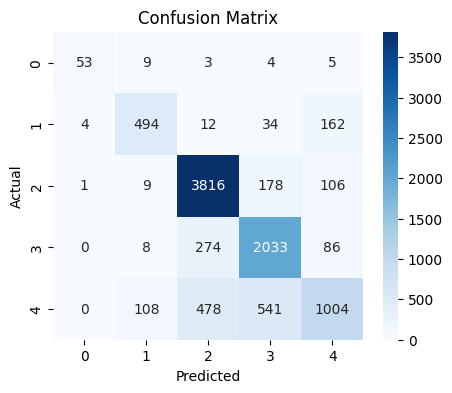

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = model.conf_matrix(X_test, y_test)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()